# 2. Modelling

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

2023-07-02 16:44:20.614474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0. Uploaded (rescaled) preprocessed images/labels and renormalise them

🚨 Section 2. can be run independently of Section 1. Please uncomment the code block below to start from here.

In [ ]:
root_dir = './drive/MyDrive' # '../' on your laptop

In [ ]:
# Load preprocessed training images and labels
train_input_dir = root_dir + '/data/preprocessed/train'

train_images = []
train_labels = []

for i in range(int(len(os.listdir(train_input_dir))/2)):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(train_input_dir, image_filename)
    image = cv2.imread(image_path)
    train_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(train_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    train_labels.append(label)

# Load preprocessed validation images and labels
val_input_dir = root_dir + '/data/preprocessed/valid'

val_images = []
val_labels = []

for i in range(int(len(os.listdir(val_input_dir))/2)):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(val_input_dir, image_filename)
    image = cv2.imread(image_path)
    val_images.append(image)

    label_filename = f"rescaled_preprocessed_label_{i}.png"
    label_path = os.path.join(val_input_dir, label_filename)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    val_labels.append(label)

# Load preprocessed test images
test_input_dir = root_dir + '/data/preprocessed/test'

test_images = []

for i in range(5):
    image_filename = f"rescaled_preprocessed_image_{i}.jpg"
    image_path = os.path.join(test_input_dir, image_filename)
    image = cv2.imread(image_path)
    test_images.append(image)

In [ ]:
# Normalize pixel values
train_images = np.array(train_images) / 255.0
train_labels = np.array(train_labels) / 255.0

val_images = np.array(val_images) / 255.0
val_labels = np.array(val_labels) / 255.0

test_images = np.array(test_images) / 255.0

## 2.1 Network Architecture

U-Net, CNN architechture suitable for image segmentation task; takes satellite image as input and generates binary mask where the roofs' boundaries are represented as white pixels (255) and the rest of the image as black (0).

Each step in the U-Net model architecture contributes to the image segmentation task of boundary detection in the following ways:

1. **Contracting Path**: The contracting path consists of a series of convolutional layers followed by max pooling layers. This path helps in capturing low-level features and spatial information from the input image. The convolutional layers extract local patterns and features, while the max pooling layers downsample the feature maps, reducing the spatial dimensions while increasing the receptive field. This allows the model to learn hierarchical representations of the input image, gradually capturing more abstract and higher-level features.

2. **Bottleneck**: The bottleneck layer is a central component of the U-Net architecture. It consists of convolutional layers applied to the output of the contracting path. This layer helps in capturing and encoding the most abstract features and information from the input image. It acts as a bridge between the contracting and expansive paths, allowing the model to capture and retain important contextual information.

3. **Expansive Path**: The expansive path is responsible for upsampling the feature maps and recovering the spatial information lost during the contracting path. It consists of upsampling layers followed by convolutional layers. The upsampling layers increase the spatial dimensions of the feature maps, while the convolutional layers refine the features and capture more detailed information. Additionally, the expansive path incorporates skip connections, where the feature maps from the contracting path are concatenated with the corresponding feature maps in the expansive path. These skip connections help in preserving spatial information and improving the model's ability to localize boundaries accurately.

4. **Output Layer**: The output layer is a single convolutional layer with a sigmoid activation function. It produces a binary mask representing the predicted boundaries for each pixel in the input image. The sigmoid activation function maps the output values to the range [0, 1], where higher values indicate the presence of a boundary. The output mask can be further processed and thresholded to generate a clear boundary map for the image.

In [ ]:
from tensorflow.keras import layers

def unet():
    inputs = keras.Input(shape=(None, None, 3))

    # Contracting Path
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path
    up1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up1 = layers.concatenate([up1, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up2 = layers.concatenate([up2, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up3 = layers.concatenate([up3, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)

    return keras.Model(inputs=inputs, outputs=outputs)


## 2.2. Model training

### 2.2.1 Model Details

* Optimizer: [Adam](https://keras.io/api/optimizers/adam/), a stochastic gradient descent method that is considered good for boundary detection. Other options are: RMSprop, SGD.
* Loss: [BinaryCrossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class), a pixel-wise loss function, which compares the predicted and ground truth boundary masks on a pixel level; useful for boundary detection.
* Metrics: [BinaryAccuracy](https://keras.io/api/metrics/accuracy_metrics/#binaryaccuracy-class) [or BinaryCrossentropy], since we are comparing against labels which have binary values.
```

In [ ]:
optimizer = 'adam' # good for boundary detection; other options: RMSprop, SGD
loss = 'binary_crossentropy'
metrics = ['binary_accuracy'] # other options: binary_crossentropy

In [ ]:
model = unet()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_285 (Conv2D)            (None, None, None,   1792        ['input_20[0][0]']               
                                64)                                                               
                                                                                                  
 conv2d_286 (Conv2D)            (None, None, None,   36928       ['conv2d_285[0][0]']             
                                64)                                                        

2.2.2 Training Details

In [ ]:
batch_size = 32 # increased in powers of 2, from 8, until statistical fluctuations between epochs stabilised
epochs = 100 # increased from 20, until the model showed signs of overfitting (train/valid curves started diverging)
validation_split = 0.3

In [ ]:
# Assuming you have loaded your training data into `train_images` and `train_masks` arrays
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

Epoch 1/100
3/3 [==============================] - 10s 1s/step - loss: 0.6664 - binary_accuracy: 0.6336 - val_loss: 0.5637 - val_binary_accuracy: 0.8736
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.5369 - binary_accuracy: 0.8789 - val_loss: 0.5091 - val_binary_accuracy: 0.8736
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.4927 - binary_accuracy: 0.8789 - val_loss: 0.4480 - val_binary_accuracy: 0.8736
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.4048 - binary_accuracy: 0.8789 - val_loss: 0.3472 - val_binary_accuracy: 0.8736
Epoch 5/100
3/3 [==============================] - 4s 1s/step - loss: 0.3513 - binary_accuracy: 0.8789 - val_loss: 0.3773 - val_binary_accuracy: 0.8736
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.3537 - binary_accuracy: 0.8789 - val_loss: 0.3360 - val_binary_accuracy: 0.8736
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.3311 - binary_a

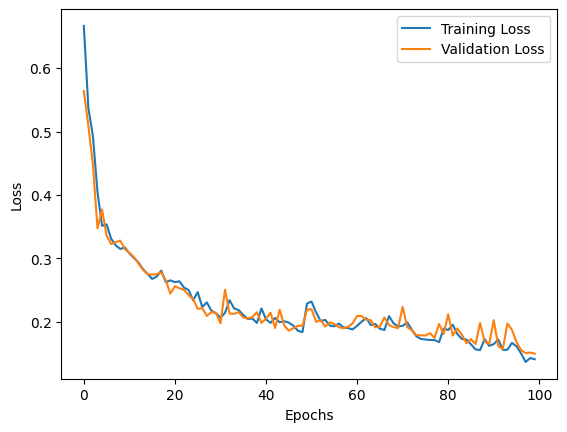

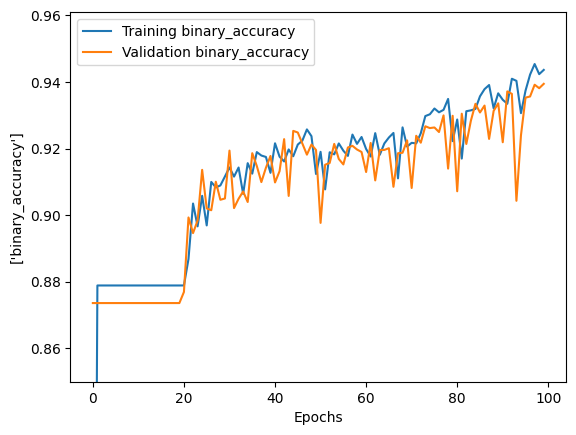

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss curve
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
for metric in metrics:
  train_metrics = history.history[f'{metric}']
  val_metrics = history.history[f'val_{metric}']

  # Plotting the Metrics curve
  plt.plot(train_metrics, label=f'Training {metrics[0]}')
  plt.plot(val_metrics, label=f'Validation {metrics[0]}')
  plt.xlabel('Epochs')
  plt.ylabel(f'{metrics}')
  plt.legend()

plt.ylim(bottom=0.85)
plt.show()

**Insights from learning curves**

* **Validation curve initially flat:** The binary accuracy curve remains flat for the first few epochs before growing, which could indicate that the model is initially struggling to learn and make meaningful predictions, but gradually improves its performance as training progresses. This can be because of several reasons, and we add this to our list of possible follow-up investigations.
* **Cyclic behaviour:** Some of the reasons might be learning rate, model architecture, data characteristics, insufficient regularisation or overfitting.

## 2.3. Model Evaluation

In [ ]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

2/2 [==============================] - 1s 170ms/step - loss: 0.1360 - binary_accuracy: 0.9439
Validation Loss: 0.1360
Validation Accuracy: 0.9439


## 2.4. Testing

Applying trained model to the test set.

In [ ]:
predictions = model.predict(test_images)

1/1 [==============================] - 0s 304ms/step


**Example prediction:** The model predicts a non-binary segmentation of the roofs from the satellite images. In order to convert them to the binary masks, that our original training labels indicated, we need to perform some postprocessing.

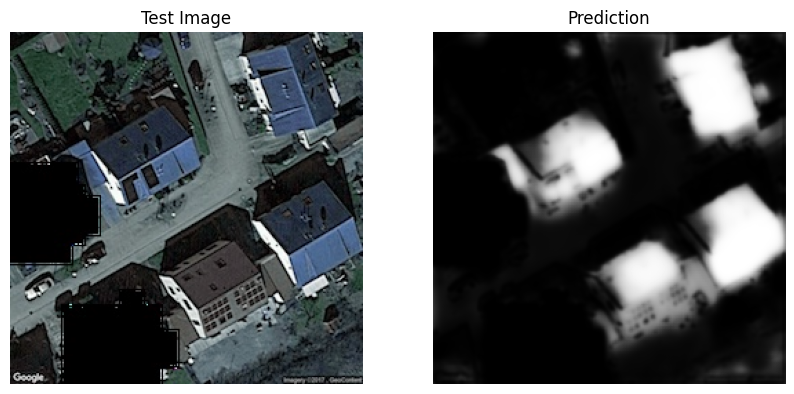

In [ ]:
i = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display test image
axes[0].imshow(test_images[i])
axes[0].set_title('Test Image')
axes[0].axis('off')

# Display prediction
axes[1].imshow(predictions[i], cmap='gray')
axes[1].set_title('Prediction')
axes[1].axis('off')

plt.show()

## 2.5. Postprocessing

In [ ]:
# Apply thresholding to convert predicted masks to binary images
def post_process(predictions, threshold=0.5):
    binary_images = (predictions > threshold).astype(np.uint8)
    return binary_images

processed_predictions = post_process(predictions, threshold=0.5)

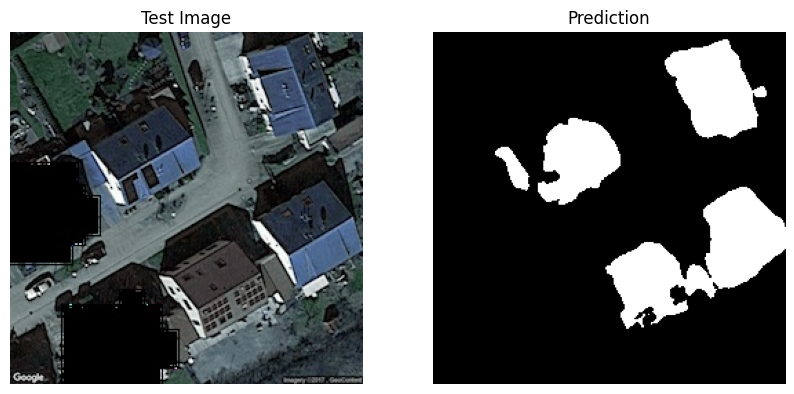

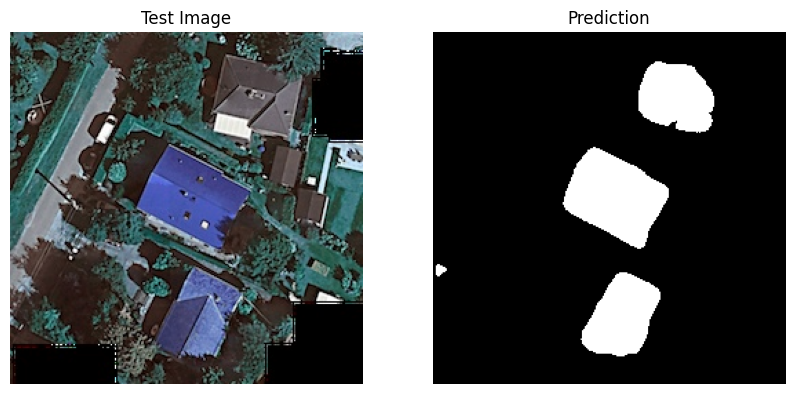

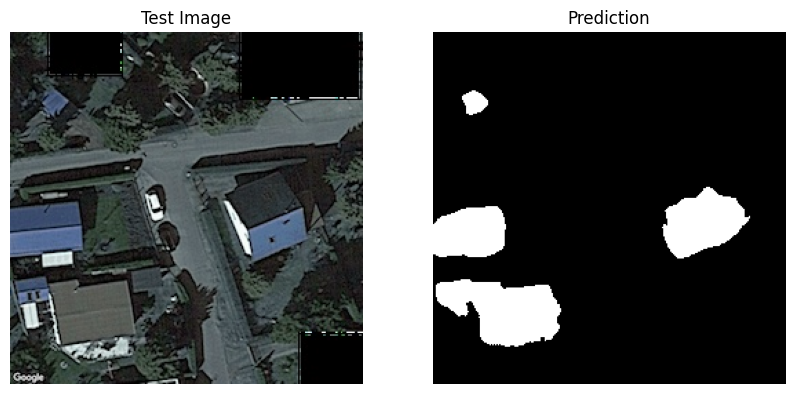

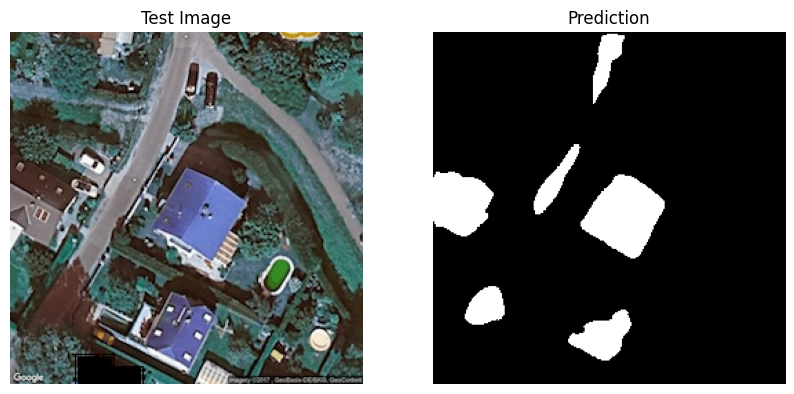

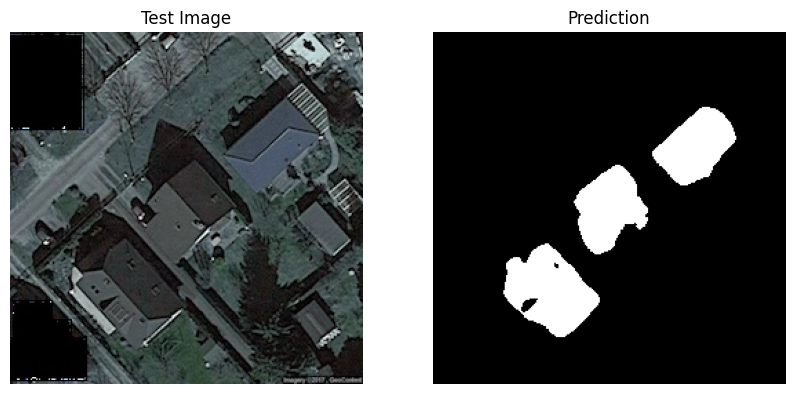

In [ ]:
for i in range(len(test_images)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display test image
    axes[0].imshow(test_images[i])
    axes[0].set_title('Test Image')
    axes[0].axis('off')

    # Display prediction
    axes[1].imshow(processed_predictions[i], cmap='gray')
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    plt.show()

## 2.6. Saving Predictions and Model

In [ ]:
# Save test images and predicted labels
test_output_dir = root_dir + '/data/predictions'
os.makedirs(test_output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    image_filename = f"test_image_{i}.jpg"
    cv2.imwrite(os.path.join(test_output_dir, image_filename), 255*image)

for i, label in enumerate(processed_predictions):
    label_filename = f"test_label_{i}.png"
    cv2.imwrite(os.path.join(test_output_dir, label_filename), 255*label)


In [ ]:
# Save the entire model
model.save(root_dir + '/models/unet_final.h5')

# Load the saved model
#from tensorflow.keras.models import load_model
#model = load_model("../models/baseline.h5")